**Installing modules and Importing Libraries**

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 812.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.0 MB/s eta 0:00:00


In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from timm import create_model
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision.models import vgg16, vgg19
from torchvision.datasets import ImageFolder
from transformers import CLIPProcessor, CLIPModel

# Task 0 (Loading the models and their eval functions)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def create_vit_model(num_classes):
    """Create a ViT model with a dynamic number of output classes."""
    model = create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)

    #Freeze all layers in the VIT model
    for param in model.parameters():
        param.requires_grad = False
    # Replace the classifier head
    model.head = torch.nn.Linear(model.head.in_features, num_classes)
    return model

def create_vgg_model(num_classes):
    """Create a VGG model with a dynamic number of output classes."""
    model = vgg16(pretrained=True)
    # Freeze all layers in the VGG model
    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier[6] = torch.nn.Linear(4096, num_classes)  # Modify the final classifier layer to match the number of classes
    return model

def init_models(num_classes):
    """Initialize ViT, VGG, and CLIP models with a dynamic number of output classes."""
    vit_model = create_vit_model(num_classes)
    vgg_model = create_vgg_model(num_classes)
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    return vit_model, vgg_model, clip_model, clip_processor

def fine_tune_model(model, train_loader, num_epochs=3, alpha=1e-3):
    """Fine-tune the discriminative models on the training data."""
    print("Finetuning the discriminative model on this data")
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=alpha)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

In [ ]:
def evaluate_model(model, data_loader,device):
    """Evaluate the discriminative models using a basic testing loop"""
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    num_batches = len(data_loader)  # Get total number of batches

    with torch.no_grad():
        for batch_index, (images, labels) in enumerate(data_loader):

            batch_size = images.size(0)
            if batch_size < 32:
              print(f"skipping last batch of size {batch_size} --- gives shape error")
              break

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Print progress every 10 batches (you can adjust this as needed)
            if batch_index % 10 == 0:
                print(f'Batch {batch_index + 1}/{num_batches} - Accuracy: { (correct/total) * 100:.2f}%')

    accuracy = correct / total
    print(f'Final Accuracy: {accuracy * 100:.2f}%')
    return accuracy


def get_text_features(class_names):
    """Get CLIP text features for the class names."""
    text_inputs = clip_processor(text=class_names, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        text_features = clip_model.get_text_features(**text_inputs)
    return text_features

def denormalize(image, mean, std):
    """Undo normalization applied in transforms for CLIP models."""
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    image = image * std + mean  # Reverse normalization
    return torch.clamp(image, 0, 1)  # Ensure pixel values are in [0, 1]


to_pil = transforms.ToPILImage() # Convert Tensor to PIL Image for CLIP model

def predict_image(image, means, stds):
    """Predict the class of a single image using CLIP."""
    image = to_pil(denormalize(image, means, stds))

    inputs = clip_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
    return image_features

def evaluate_clip_model(data_loader, class_names,device, means, stds):
    """Evaluate the zero shot CLIP model using similairty matrix and loss func (no training)"""
    text_features = get_text_features(class_names)
    correct = 0
    total = 0
    num_batches = len(data_loader)  # Get total number of batches

    for batch_index, (images, labels) in enumerate(data_loader):
        image = images[0]  # For batch size 1
        true_label = labels[0].item()
        image_features = predict_image(image,means,stds)

        # Compute similarity between image and all text features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        similarity = torch.matmul(image_features, text_features.T)

        # Predict the class
        predicted_class = similarity.argmax().item()
        if predicted_class == true_label:
            correct += 1
        total += 1

        # Print progress every 500 batches (you can adjust this as needed)
        if batch_index % 500 == 0:
            print(f'Batch {batch_index + 1}/{num_batches} - Accuracy: { (correct/total) * 100:.2f}%')

    accuracy = correct / total
    return accuracy

In [ ]:
# del vit_model
# del vgg_model
# del clip_model
# del clip_processor
# torch.cuda.empty_cache()

#Initialise and always finetune the models on that specific training set
vit_model, vgg_model, clip_model, clip_processor = init_models(num_classes=?)  #num_classes depending on the dataset
# fine_tune_model(vit_model, train_loader)
# fine_tune_model(vgg_model, train_loader)

# Task 4 (Evaluating the 3 models for Semantic Bias )

In [ ]:
# 1) Shape Bias ------------> apply segmentation/masking to extract outline/silhouettes of objects from dataset
# Shape Bias =   biased_dataset_accuracy / total_accuracy

# 2) Texture Bias ----------> apply style transfer to a dataset and
# Texture Bias = biased_dataset_accuracy / total_accuracy

# 3) Color Bias ------------> apply color shift to a dataset and   (evaluate using MNIST and COLOR_MNIST)
# Color Bias =   biased_dataset_accuracy / total_accuracy

# Task 5 (Evaluating the 3 models for Locality Bias ---> on CIFAR10 Dataset)

**Loading the models and dataset**

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # works for all models
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.2435, 0.2616))  # CIFAR-10 mean and std
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
clip_test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f'Total number of images in CIFAR 10 test_loader: {len(test_dataset)}')

cifar10_classes = [
    'airplane', 'automobile',  'ship', 'truck'
    'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
]

Files already downloaded and verified
Files already downloaded and verified
Total number of images in CIFAR 10 test_loader: 10000


In [ ]:
# del vit_model
# del vgg_model
# del clip_model
# del clip_processor
# torch.cuda.empty_cache()
vit_model, vgg_model, clip_model, clip_processor = init_models(num_classes=10)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 219MB/s]


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Util functions

In [ ]:
def load_image(image_input):
    if not isinstance(image_input, torch.Tensor):
        image = Image.open(image_input)
        image = image.resize((224, 224), Image.LANCZOS)
        image_array = np.array(image)
    else:  #tensors from dataset are already resized
      image = image_input
      if image_input.dim() == 4:  #extra batch dimension
        image_array = image_input.squeeze(0).cpu().numpy()
      else:
        image_array = image_input.cpu().numpy()


    if isinstance(image_input, torch.Tensor):  #transpose the tensor from dataset from viewing in plot if required
      image_array = np.transpose(image_array,(1, 2, 0))  # Convert CHW to HWC

    return image_array

In [ ]:
# Creating folders
# directory_name = 'generated_dataset/images'  # Change this to your desired folder name
# full_path = os.path.join('/content', directory_name)
# os.makedirs(full_path, exist_ok=True)
# file_path = '/content/generated_dataset/labels.txt'
# with open(file_path, 'w') as f:
#     pass
# print(f"Empty file created at: {file_path}")

Empty file created at: /content/generated_dataset/labels.txt


In [ ]:
# # # Delete all files inside the folder

# folder_path = '/content/shortened_dataset/images'
# if os.path.exists(folder_path):
#     for filename in os.listdir(folder_path):
#         file_path = os.path.join(folder_path, filename)
#         try:
#             if os.path.isfile(file_path):  # Check if it is a file
#                 os.remove(file_path)      # Delete the file
#         except Exception as e:
#             print(f"Error deleting file {file_path}: {e}")

<ipython-input-22-b3a46348f9c0>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_tensor = torch.load(tensor_path)


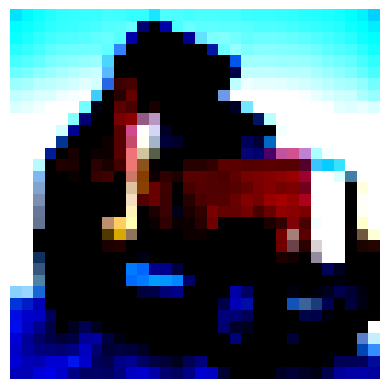

In [ ]:
# Viewing a tensor
# tensor_path = '/content/generated_dataset/images/img_0002.pt'  # Adjust this to your desired image tensor
# img_tensor = torch.load(tensor_path)
# img  = load_image(img_tensor)
# plt.imshow(img)
# plt.axis('off')  # Remove axis lines and labels
# plt.show()

# tensor_path = '/content/shortened_dataset/images/img_0002.pt'  # Adjust this to your desired image tensor
# img_tensor = torch.load(tensor_path)
# img  = load_image(img_tensor)
# plt.imshow(img)
# plt.axis('off')  # Remove axis lines and labels
# plt.show()

# Creating short datatset and saving it to zip file

In [ ]:
#Creating shortened dataset (of 1000 images) from test dataset (of 10000 images) w/ stratification

from torch.utils.data import Subset
from collections import defaultdict

class_indices = defaultdict(list)
for idx, (image, label) in enumerate(test_dataset):
    class_indices[label].append(idx)

np.random.seed(42)  # For reproducibility
shortened_indices = []

for class_label, indices in class_indices.items():
    selected_indices = np.random.choice(indices, 100, replace=False)
    shortened_indices.extend(selected_indices)

shortened_dataset = Subset(test_dataset, shortened_indices)
shortened_loader = DataLoader(shortened_dataset, batch_size=32, shuffle=True)
print(f'Total samples in the shortened dataset: {len(shortened_dataset)}')

# To verify class distribution
class_count = defaultdict(int)
for _, label in shortened_dataset:
    class_count[label] += 1
for class_label, count in class_count.items():
    print(f'Class {class_label}: {count} samples')  #100 samples per class

Total samples in the shortened dataset: 1000
Class 3: 100 samples
Class 8: 100 samples
Class 0: 100 samples
Class 6: 100 samples
Class 1: 100 samples
Class 9: 100 samples
Class 5: 100 samples
Class 7: 100 samples
Class 4: 100 samples
Class 2: 100 samples


In [ ]:
import os
import torch
import zipfile

# # Step 1: Create a directory to store the image tensors and labels
output_dir = '/content/shortened_dataset'
images_dir = os.path.join(output_dir, 'images')
labels_file = os.path.join(output_dir, 'labels.txt')

os.makedirs(images_dir, exist_ok=True)

# Step 2: Loop through the shortened_loader and save the tensors and labels
for batch_idx, (images, labels) in enumerate(shortened_loader):
    for i in range(images.size(0)):
        img_tensor = images[i]  # Tensor for each image
        label = labels[i].item()  # Class label for each image

        # Save tensor to .pt file
        torch.save(img_tensor, f"{images_dir}/img_{(batch_idx * shortened_loader.batch_size) + i:04d}.pt")

        # Append label to labels.txt
        with open(labels_file, 'a') as f:
            f.write(f"img_{(batch_idx * shortened_loader.batch_size) + i:04d}.pt {label}\n")

# Step 3: Zip the folder containing the image tensors and labels
!zip -r /content/shortened_dataset/images.zip /content/shortened_dataset

In [ ]:
# zip_filename = '/content/shortened_dataset.zip'
# unzip_dir = '/content/shortened_dataset_unzipped'
# with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
#     zip_ref.extractall(unzip_dir)

# Define paths for images and labels
unzip_dir = '/content/shortened_dataset'
images_dir = os.path.join(unzip_dir, 'images')
labels_file = os.path.join(unzip_dir, 'labels.txt')

# Step 2: Load the image tensors and labels
def load_images_and_labels(images_dir, labels_file):
    image_tensors = []
    labels = []
    imgnames = []

    with open(labels_file, 'r') as f:
        for line in f:
            img_name, label = line.strip().split()  # Splitting the line to extract the label
            labels.append(int(label))
            imgnames.append(img_name)

    for i in range(len(labels)):
        img_tensor = torch.load(os.path.join(images_dir, imgnames[i]))
        image_tensors.append(img_tensor)

    return image_tensors, labels

# Load the image tensors and labels
shortened_imgs, shortened_labels = load_images_and_labels(images_dir, labels_file)
print(len(shortened_imgs), len(shortened_labels))

<ipython-input-27-5354efa210f2>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_tensor = torch.load(os.path.join(images_dir, imgnames[i]))


1000 1000


# **Localised Noise Injection**

In [ ]:
def add_localized_noise(img, patch_size=76, noise_std=2.0):
    """
    Add Gaussian noise to a localized region in the image.

    Args:
        img: A tensor representing the image (C x H x W).
        patch_size: The size of the square patch to apply noise to.
        noise_std: The standard deviation of the Gaussian noise.

    Returns:
        Noisy image with Gaussian noise applied to a localized region.
    """

    noisy_img = img.clone()

    # Select a fixed region for applying noise
    start_x = 112 - patch_size // 2
    start_y = 112 - patch_size // 2

    # Generate Gaussian noise
    noise = torch.randn((3, patch_size, patch_size)) * noise_std

    # print(f"region where noise is added ---> x: {start_x}:{start_x + patch_size} -----> y: {start_y}:{start_y + patch_size} ")

    # Apply noise to the localized region
    noisy_img[:, start_x:start_x + patch_size, start_y:start_y + patch_size] += noise

    return torch.clamp(noisy_img, 0, 1)  # Clamp to ensure pixel values are in valid range

# Add localised noise to CIFAR-10 images
def apply_local_noise(data_loader):
    noised_images = []
    labels_list = []
    for images, labels in data_loader:
        for i,image in enumerate(images):
            noisy_img = add_localized_noise(image)
            noised_images.append(noisy_img.unsqueeze(0))
            labels_list.append(labels[i].unsqueeze(0))

    # print(len(noised_images), len(labels_list))
    return torch.cat(noised_images), torch.cat(labels_list)

noised_images, noised_labels = apply_local_noise(test_loader)

In [ ]:
print(len(noised_images), len(noised_labels),noised_images[0].shape)
print(noised_labels)

10000 10000 torch.Size([3, 224, 224])
tensor([3, 8, 8,  ..., 5, 1, 7])


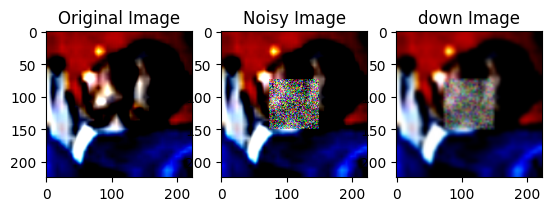

In [ ]:
sample_img, label = test_dataset[0]

# Visualize the original and noisy image
plt.subplot(1, 3, 1)
plt.imshow(np.transpose(sample_img.numpy(), (1, 2, 0)))
plt.title('Original Image')


noisy_img = add_localized_noise(sample_img)

plt.subplot(1, 3, 2)
plt.imshow(np.transpose(noisy_img.numpy(), (1, 2, 0)))
plt.title('Noisy Image')

downsize_transform = transforms.Resize((80, 80))
down_img = downsize_transform(noisy_img)
upsize_transform = transforms.Resize((224, 224))
up_img = upsize_transform(down_img)

plt.subplot(1, 3, 3)
plt.imshow(np.transpose(up_img.numpy(), (1, 2, 0)))
plt.title('down Image')
plt.show()

In [ ]:
# Creating folders
directory_name = 'generated_dataset/images'  # Change this to your desired folder name
full_path = os.path.join('/content', directory_name)
os.makedirs(full_path, exist_ok=True)
file_path = '/content/generated_dataset/labels.txt'
with open(file_path, 'w') as f:
    pass
print(f"Empty file created at: {file_path}")

Empty file created at: /content/generated_dataset/labels.txt


In [ ]:
# import shutil
# shutil.rmtree('/content/generated_dataset')

In [ ]:
labels_file = 'generated_dataset/labels.txt'
downsize_transform = transforms.Resize((80, 80))

with open(labels_file, 'w') as f:
    for idx, (image_tensor, label) in enumerate(zip(noised_images, noised_labels)):

        # Create the file name
        image_file_name = f'img_{idx:04d}.pt'
        image_path = os.path.join(directory_name, image_file_name)

        image_tensor = downsize_transform(image_tensor)

        # Save the image tensor
        torch.save(image_tensor, image_path)

        # Write the image file name and its corresponding label to the labels.txt file
        f.write(f'{image_file_name} {label}\n')

In [ ]:
!zip -r /content/generated_dataset/images.zip /content/generated_dataset

Streaming output truncated to the last 5000 lines.
  adding: content/generated_dataset/images/img_8672.pt (deflated 52%)
  adding: content/generated_dataset/images/img_4950.pt (deflated 55%)
  adding: content/generated_dataset/images/img_2786.pt (deflated 55%)
  adding: content/generated_dataset/images/img_1701.pt (deflated 75%)
  adding: content/generated_dataset/images/img_4879.pt (deflated 85%)
  adding: content/generated_dataset/images/img_7920.pt (deflated 44%)
  adding: content/generated_dataset/images/img_0126.pt (deflated 50%)
  adding: content/generated_dataset/images/img_9420.pt (deflated 65%)
  adding: content/generated_dataset/images/img_2031.pt (deflated 56%)
  adding: content/generated_dataset/images/img_8174.pt (deflated 59%)
  adding: content/generated_dataset/images/img_2308.pt (deflated 53%)
  adding: content/generated_dataset/images/img_8793.pt (deflated 59%)
  adding: content/generated_dataset/images/img_1875.pt (deflated 71%)
  adding: content/generated_dataset/ima

<ipython-input-101-a2298a956df0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_tensor = torch.load(tensor_path)


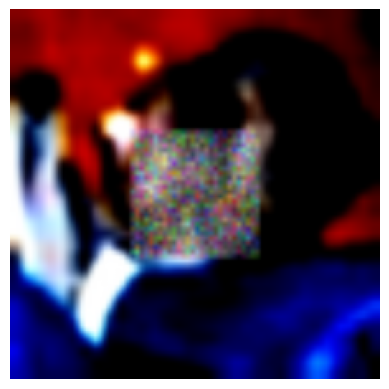

In [ ]:
tensor_path = '/content/generated_dataset/images/img_0000.pt'  # Adjust this to your desired image tensor
img_tensor = torch.load(tensor_path)
img_tensor = upsize_transform(img_tensor)
img  = load_image(img_tensor)
plt.imshow(img)
plt.axis('off')  # Remove axis lines and labels
plt.show()

In [ ]:
# file_path = '/content/generated_dataset/images.zip'
# file_size = os.path.getsize(file_path) / (1024 * 1024)  # Convert bytes to MB
# print(f"File size: {file_size:.2f} MB")

File size: 321.39 MB


In [ ]:
noised_dataset = TensorDataset(noised_images, noised_labels)
noised_loader = DataLoader(noised_dataset, batch_size=32, shuffle=True)          # Create a new dataset for noised images
clip_noised_loader = DataLoader(noised_dataset, batch_size=1, shuffle=True) # Create a new dataset for noised images for CLIP

print('Evaluating the Discriminative Models...')
vit_accuracy = evaluate_model(vit_model, noised_loader,device)
print(f"ViT Accuracy on CIFAR 10 w/ Local Noise: {vit_accuracy * 100:.2f}%")

vgg_accuracy = evaluate_model(vgg_model, noised_loader,device)
print(f"VGG Accuracy on CIFAR 10 w/ Local Noise: {vgg_accuracy * 100:.2f}%")

print('Evaluating the Contrastive Model...')
clip_accuracy = evaluate_clip_model(clip_noised_loader, cifar10_classes, device, means=(0.4914, 0.4822, 0.4465),stds=(0.247, 0.2435, 0.2616))
print(f'CLIP (Zero-Shot) Accuracy on CIFAR 10 w/ Local Noise: {clip_accuracy * 100:.2f}%')

Evaluating the Contrastive Model...
Batch 1/10000 - Accuracy: 100.00%
Batch 501/10000 - Accuracy: 51.70%
Batch 1001/10000 - Accuracy: 51.85%


KeyboardInterrupt: 

# **Global style changes** (see **texture_bias_dataset.ipynb**)

# **Scrambling images**

In [ ]:
def scramble_image(image, patch_size=32):
    """Scramble the image by randomly permuting patches."""
    # Convert the image to a NumPy array and get dimensions
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Change to HWC format
    h, w, c = image_np.shape

    # Calculate the number of patches
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image_np[i:i + patch_size, j:j + patch_size, :]
            patches.append(patch)

    # Randomly shuffle the patches
    np.random.shuffle(patches)

    # Reconstruct the image from scrambled patches
    scrambled_image = np.zeros_like(image_np)
    idx = 0
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            scrambled_image[i:i + patch_size, j:j + patch_size, :] = patches[idx]
            idx += 1

    return torch.tensor(scrambled_image).permute(2, 0, 1)  # Change back to CHW format


def apply_scrambling(data_loader):
    scrambled_images = []
    labels_list = []

    for images, labels in data_loader:
        for i,image in enumerate(images):
            scrambled_image = scramble_image(image)
            scrambled_images.append(scrambled_image.unsqueeze(0))  # Add batch dimension
            labels_list.append(labels[i].unsqueeze(0))             # Add batch dimension

    return torch.cat(scrambled_images), torch.cat(labels_list)

scrambled_images, scrambled_labels = apply_scrambling(test_loader)

In [ ]:
print(len(scrambled_images), len(scrambled_labels),scrambled_images[0].shape)
print(scrambled_labels)

10000 10000 torch.Size([3, 224, 224])
tensor([3, 8, 8,  ..., 5, 1, 7])


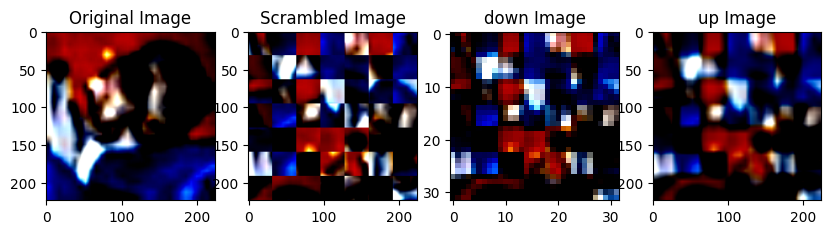

In [ ]:
sample_img, label = test_dataset[0]

plt.figure(figsize=(10, 10))
# Visualize the original and noisy image
plt.subplot(1, 4, 1)
plt.imshow(np.transpose(sample_img.numpy(), (1, 2, 0)))
plt.title('Original Image')

noisy_img = scramble_image(sample_img)

plt.subplot(1, 4, 2)
plt.imshow(np.transpose(noisy_img.numpy(), (1, 2, 0)))
plt.title('Scrambled Image')
# plt.show()

downsize_transform = transforms.Resize((32, 32))
upsize_transform = transforms.Resize((224, 224))

down_img = downsize_transform(noisy_img)

plt.subplot(1, 4, 3)
plt.imshow(np.transpose(down_img.numpy(), (1, 2, 0)))
plt.title('down Image')

up_img = upsize_transform(down_img)

plt.subplot(1, 4, 4)
plt.imshow(np.transpose(up_img.numpy(), (1, 2, 0)))
plt.title('up Image')
plt.show()

In [ ]:
# # Creating folders
# directory_name = 'generated_dataset/images'  # Change this to your desired folder name
# full_path = os.path.join('/content', directory_name)
# os.makedirs(full_path, exist_ok=True)
# file_path = '/content/generated_dataset/labels.txt'
# with open(file_path, 'w') as f:
#     pass
# print(f"Empty file created at: {file_path}")

Empty file created at: /content/generated_dataset/labels.txt


In [ ]:
labels_file = 'generated_dataset/labels.txt'
downsize_transform = transforms.Resize((32, 32))

with open(labels_file, 'w') as f:
    for idx, (image_tensor, label) in enumerate(zip(scrambled_images, scrambled_labels)):
        image_tensor = downsize_transform(image_tensor)

        # Create the file name
        image_file_name = f'img_{idx:04d}.pt'
        image_path = os.path.join(directory_name, image_file_name)

        # Save the image tensor
        torch.save(image_tensor, image_path)

        # Write the image file name and its corresponding label to the labels.txt file
        f.write(f'{image_file_name} {label}\n')

In [ ]:
!zip -r /content/generated_dataset/images.zip /content/generated_dataset

Streaming output truncated to the last 5000 lines.
  adding: content/generated_dataset/images/img_8672.pt (deflated 12%)
  adding: content/generated_dataset/images/img_4950.pt (deflated 12%)
  adding: content/generated_dataset/images/img_2786.pt (deflated 12%)
  adding: content/generated_dataset/images/img_1701.pt (deflated 14%)
  adding: content/generated_dataset/images/img_4879.pt (deflated 16%)
  adding: content/generated_dataset/images/img_7920.pt (deflated 12%)
  adding: content/generated_dataset/images/img_0126.pt (deflated 11%)
  adding: content/generated_dataset/images/img_9420.pt (deflated 13%)
  adding: content/generated_dataset/images/img_2031.pt (deflated 12%)
  adding: content/generated_dataset/images/img_8174.pt (deflated 12%)
  adding: content/generated_dataset/images/img_2308.pt (deflated 12%)
  adding: content/generated_dataset/images/img_8793.pt (deflated 12%)
  adding: content/generated_dataset/images/img_1875.pt (deflated 22%)
  adding: content/generated_dataset/ima

<ipython-input-15-a2298a956df0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_tensor = torch.load(tensor_path)


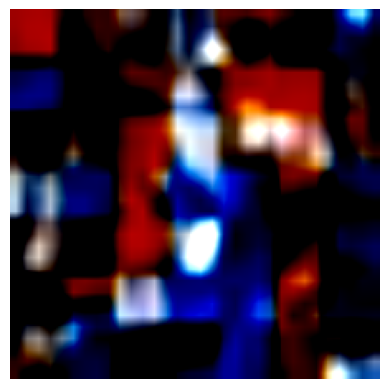

In [ ]:
tensor_path = '/content/generated_dataset/images/img_0000.pt'  # Adjust this to your desired image tensor
img_tensor = torch.load(tensor_path)
img_tensor = upsize_transform(img_tensor)
img  = load_image(img_tensor)
plt.imshow(img)
plt.axis('off')  # Remove axis lines and labels
plt.show()

In [ ]:
scrambled_dataset = TensorDataset(scrambled_images, scrambled_labels)
scrambled_loader = DataLoader(scrambled_dataset, batch_size=32, shuffle=True)           # Create a new dataset for scrambled images
clip_scrambled_loader = DataLoader(scrambled_dataset, batch_size=1, shuffle=True)  # Create a new dataset for scrambled images for CLIP

print('Evaluating the Discriminative Models...')
vit_accuracy = evaluate_model(vit_model, scrambled_loader,device)
print(f"ViT Accuracy on CIFAR 10 w/ Scrambling: {vit_accuracy * 100:.2f}%")

vgg_accuracy = evaluate_model(vgg_model, scrambled_loader,device)
print(f"VGG Accuracy on CIFAR 10 w/ Scrambling: {vgg_accuracy * 100:.2f}%")

print('Evaluating the Contrastive Model...')
clip_accuracy = evaluate_clip_model(clip_scrambled_loader, cifar10_classes, device, means=(0.4914, 0.4822, 0.4465),stds=(0.247, 0.2435, 0.2616))
print(f'CLIP (Zero-Shot) Accuracy on CIFAR 10 w/ Scrambling: {clip_accuracy * 100:.2f}%')

Evaluating the Contrastive Model...
Batch 1/10000 - Accuracy: 0.00%
Batch 501/10000 - Accuracy: 27.94%


KeyboardInterrupt: 